In [1]:
import datetime

import matplotlib as mp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


sns.set()
sns.set_style('whitegrid')
sns.set_style('ticks')

In [2]:
save_suffix = '2022-06-22'
date_run = datetime.datetime(2022,6,22)

# data

In [3]:
data = pd.read_csv('planning-department-records-2022/ppts.csv.xz',
                   parse_dates=[
                       'OPEN_DATE',
                       'CLOSE_DATE',
                   ],
                   infer_datetime_format=True,
                   compression='xz')

/var/folders/36/sf9k268s0c34cwx__rdbvhtm0000gn/T/ipykernel_13117/2322658156.py:1: DtypeWarning: Columns (3,7,8,14,24,25,26,27,28,37,38,39,40,41,42,43,44,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,69,70,71,72,73,74,75,76,77,80,81,82,83,84,85,86,87,88,90) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('planning-department-records-2022/ppts.csv.xz',


In [4]:
# prj is a decent first-approximation of the first time planning learns about a project
prj = data[data['RECORD_TYPE'] == 'PRJ']

In [5]:
# Find all projects with any units proposed
market_res_units = [
    'NUMBER_MARKET_RATE_UNITS_EXIST',
    'NUMBER_MARKET_RATE_UNITS_PROP',
    'NUMBER_OF_MARKET_RATE_UNITS',
]
aff_res_units = [
    'NUMBER_AFFORDABLE_UNITS_EXIST',
    'NUMBER_AFFORDABLE_UNITS_PROPOSED',
    'NUMBER_OF_AFFORDABLE_UNITS',
]

res_units = market_res_units + aff_res_units

q = ~pd.isna(prj[res_units[0]])
for r in res_units[1:]:
    q |= ~pd.isna(prj[r])
prj_res = prj[q]

In [6]:
# Remove anything which has 0 market and 0 subsidized units
prj_res = prj_res[(prj_res.NUMBER_OF_MARKET_RATE_UNITS > 0) | (prj_res.NUMBER_OF_AFFORDABLE_UNITS > 0)]
# Exclude anything with dates past today
prj_res = prj_res[prj_res.OPEN_DATE < date_run]
# Don't look back too far; data from before 2014 is unreliable
prj_res = prj_res[prj_res.OPEN_DATE > datetime.datetime(2014,7,1)]

In [7]:
len(prj_res)

3904

In [8]:
def quarter(dt):
    return "%s Q%s" % (dt.year, int(np.ceil((dt.month)/3)))


def half(dt):
    return "%s H%s" % (dt.year, int(np.ceil((dt.month)/6)))


def monthyear(dt):
    return "%s %s" % (dt.year, dt.strftime("%b"))

prj_res['_year'] = prj_res['OPEN_DATE'].apply(lambda dt: str(dt.year))
prj_res['_quarter'] = prj_res['OPEN_DATE'].apply(quarter)
prj_res['_half'] = prj_res['OPEN_DATE'].apply(half)
prj_res['_month'] = prj_res['OPEN_DATE'].apply(monthyear)

# Analysis

In [9]:
len(data[data.OPEN_DATE.dt.year == 2022])

5253

In [10]:
for year in range(2010, 2023):
    print("%s: %s" % (year, data[data.OPEN_DATE.dt.year == year][['NUMBER_AFFORDABLE_UNITS_PROPOSED', 'NUMBER_MARKET_RATE_UNITS_PROP']].sum().sum()))

2010: 4406
2011: 3065
2012: 3950
2013: 4433
2014: 7937
2015: 15451
2016: 9508
2017: 11236
2018: 12816
2019: 8093
2020: 8043
2021: 14264
2022: 8277


In [11]:
before = prj_res[prj_res.OPEN_DATE < datetime.datetime(2016,7,1)]  # Before Prop C
after = prj_res[prj_res.OPEN_DATE >= datetime.datetime(2016,7,1)]  # After Prop C

In [12]:
before['NUMBER_OF_MARKET_RATE_UNITS'].sum()

15780

## All projects with some market-rate units

In [13]:
mrk_data = prj_res.groupby('_half').aggregate({'NUMBER_OF_MARKET_RATE_UNITS': 'sum'})
d = mrk_data.NUMBER_OF_MARKET_RATE_UNITS.values.tolist()
params = np.polyfit(range(len(d)), d, 1)
poly = np.poly1d(params)

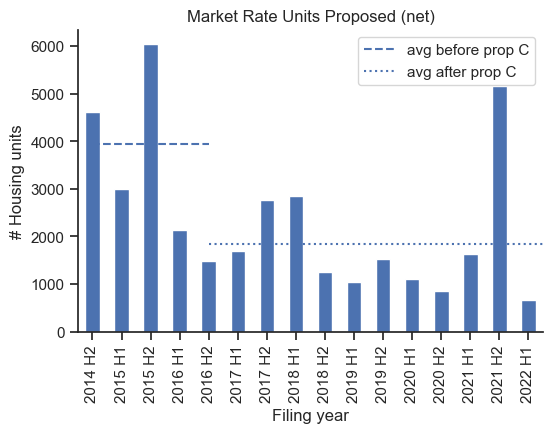

In [14]:
mrk_data = prj_res.groupby('_half').aggregate({'NUMBER_OF_MARKET_RATE_UNITS': 'sum'})
num_quarters = len(mrk_data)

d = mrk_data.NUMBER_OF_MARKET_RATE_UNITS.values.tolist()
params = np.polyfit(range(len(d)), d, 1)
poly = np.poly1d(params)

mrk_data_before = before.groupby('_half').aggregate({'NUMBER_OF_MARKET_RATE_UNITS': 'sum'})
d = mrk_data_before.NUMBER_OF_MARKET_RATE_UNITS.values.tolist()
offset = len(d)
avg_before = np.mean(d)

mrk_data_after = after.groupby('_half').aggregate({'NUMBER_OF_MARKET_RATE_UNITS': 'sum'})
d = mrk_data_after.NUMBER_OF_MARKET_RATE_UNITS.values.tolist()
avg_after = np.mean(d)

f = mp.pyplot.figure()
ax = f.gca()
p = mrk_data.plot.bar(ax=ax)
p.set_label("_nolegend_")


l2 = ax.hlines(avg_before, 0, offset, label='avg before', linestyles='dashed')
l3 = ax.hlines(avg_after, offset, len(d) + offset, label='avg after', linestyles='dotted')
mp.pyplot.title("Market Rate Units Proposed (net)")
ax.set_ylabel("# Housing units")
ax.set_xlabel("Filing year")
#ax.legend()
ax.legend((l2, l3), ('avg before prop C', 'avg after prop C'))
sns.despine()
f.set_dpi(100)
f.savefig("figs/market-rate-net-%s.png" % save_suffix, dpi=300, bbox_inches='tight')

## All Affordable units

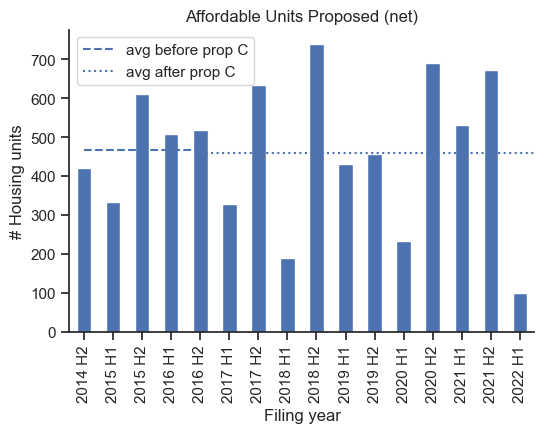

In [15]:
aff_data = prj_res.groupby('_half').aggregate({'NUMBER_OF_AFFORDABLE_UNITS': 'sum'})
d = aff_data.NUMBER_OF_AFFORDABLE_UNITS.values.tolist()
params = np.polyfit(range(len(d)), d, 1)
poly = np.poly1d(params)

aff_data_before = before.groupby('_half').aggregate({'NUMBER_OF_AFFORDABLE_UNITS': 'sum'})
d = aff_data_before.NUMBER_OF_AFFORDABLE_UNITS.values.tolist()
offset = len(d)
avg_before = np.mean(d)

aff_data_after = after.groupby('_half').aggregate({'NUMBER_OF_AFFORDABLE_UNITS': 'sum'})
d = aff_data_after.NUMBER_OF_AFFORDABLE_UNITS.values.tolist()
avg_after = np.mean(d)

f = mp.pyplot.figure()
ax = f.gca()
p = aff_data.plot.bar(ax=ax)
p.set_label("_nolegend_")

l2 = ax.hlines(avg_before, 0, offset, label='avg before', linestyles='dashed')
l3 = ax.hlines(avg_after, offset, len(d) + offset, label='avg after', linestyles='dotted')
mp.pyplot.title("Affordable Units Proposed (net)")
ax.set_ylabel("# Housing units")
ax.set_xlabel("Filing year")
#ax.legend()
ax.legend((l2, l3), ('avg before prop C', 'avg after prop C'))
sns.despine()

f.set_dpi(100)
f.savefig("figs/affordable-net-%s.png" % save_suffix, dpi=300, bbox_inches='tight')

## Break down by project type

The percentage of subsidized affordable units mandated by law varies according to the size of the project:

* Fewer than 10 units: 0%
* Fewer than 25 units: 12%
* 25 or more units: 20%

The old requirement was a flat 12% on projects with more than 10 units, so we can compare the classes of projects to get an estimate for the impact of Prop C.

In [18]:
def project_type(mrk_units):
    if not mrk_units:
        return "NA"
    if int(mrk_units) < 10:
        return "0"
    elif int(mrk_units) < 25:
        return "12"
    else:
        return "18+"
    
prj_res['_project_type'] = prj_res[prj_res['NUMBER_OF_MARKET_RATE_UNITS']>0]['NUMBER_OF_MARKET_RATE_UNITS'].apply(project_type)

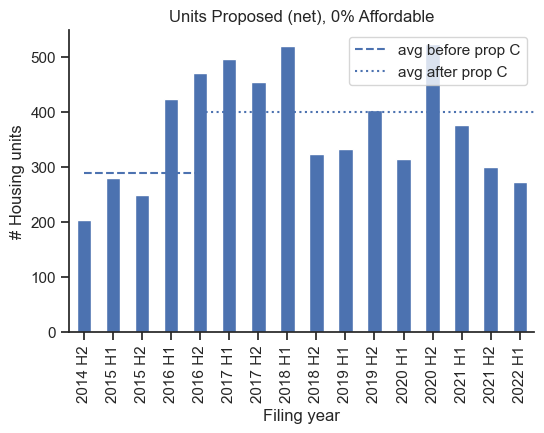

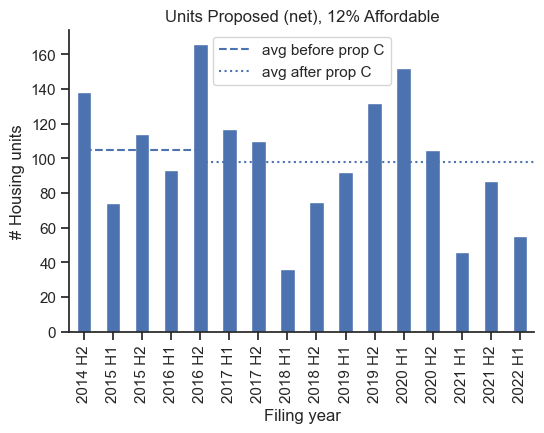

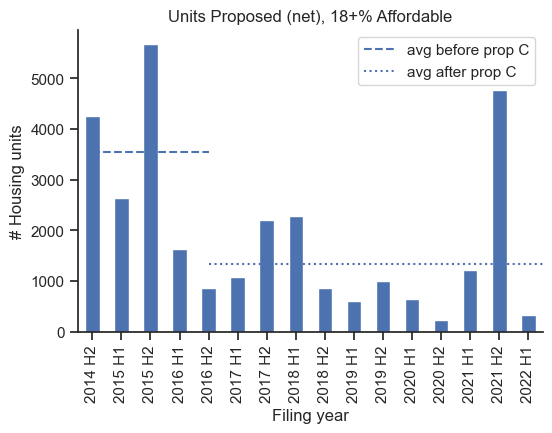

In [19]:
before = prj_res[prj_res.OPEN_DATE < datetime.datetime(2016,7,1)]  # Before Prop C
after = prj_res[prj_res.OPEN_DATE >= datetime.datetime(2016,7,1)]  # After Prop C

mrk_data = prj_res.groupby(['_half', '_project_type']).aggregate({'NUMBER_OF_MARKET_RATE_UNITS': 'sum'})
# 2018Q3 has no projects in the 12 and 18-20 buckets, so they're missing from the groupby/aggregate, so add them in
# mrk_data.loc[('2018 Q3', '12'), 'NUMBER_OF_MARKET_RATE_UNITS'] = 0
# mrk_data.loc[('2018 Q3', '18-20'), 'NUMBER_OF_MARKET_RATE_UNITS'] = 0
mrk_data_before = before.groupby(['_half', '_project_type']).aggregate({'NUMBER_OF_MARKET_RATE_UNITS': 'sum'})
mrk_data_after = after.groupby(['_half', '_project_type']).aggregate({'NUMBER_OF_MARKET_RATE_UNITS': 'sum'})

idx = pd.IndexSlice
for c, _project_type in enumerate(['0', '12', '18+']):
    _mrk = mrk_data.loc[idx[:, _project_type], idx[:]]
    # Clean up indices for plotting
    _mrk = _mrk.reset_index().set_index('_half').drop(columns=['_project_type'])
    _mrk_before = mrk_data_before.loc[idx[:, _project_type], idx[:]]
    _mrk_after = mrk_data_after.loc[idx[:, _project_type], idx[:]]
    
    d = _mrk.NUMBER_OF_MARKET_RATE_UNITS.values.tolist()
    params = np.polyfit(range(len(d)), d, 1)
    poly = np.poly1d(params)

    d = _mrk_before.NUMBER_OF_MARKET_RATE_UNITS.values.tolist()
    offset = len(d)
    avg_before = np.mean(d)

    d = _mrk_after.NUMBER_OF_MARKET_RATE_UNITS.values.tolist()
    avg_after = np.mean(d)
    f = mp.pyplot.figure()
    ax = f.gca()
    #ax = axarr[c]
    #p = _mrk.plot.bar(x=_mrk.index.levels[0], ax=ax)
    p = _mrk.plot.bar(ax=ax)
    #p.set_label("_nolegend_")

    l2 = ax.hlines(avg_before, 0, offset, label='avg before', linestyles='dashed')
    l3 = ax.hlines(avg_after, offset, len(d) + offset, label='avg after', linestyles='dotted')
    ax.set_xlabel("%s%% Affordable" % _project_type)

    #ax.legend()
    mp.pyplot.title("Units Proposed (net), %s%% Affordable" % _project_type)
    ax.set_ylabel("# Housing units")
    ax.set_xlabel("Filing year")
    #ax.legend()
    ax.legend((l2, l3), ('avg before prop C', 'avg after prop C'))
    sns.despine()
    f.set_dpi(100)
    if c == 0:
        ax.legend((l2, l3), ('avg before prop C', 'avg after prop C'))
    sns.despine()
    f.set_dpi(100)
    f.savefig("figs/market-rate-net-%s-affordable-%s.png" % (_project_type, save_suffix), dpi=100, bbox_inches='tight')